In [ ]:
# Commande pour vérifier si le GPU est bien actif

In [ ]:
#!pip install keras-tuner --upgrade

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow

from datetime import datetime

In [ ]:
# On se place dans le drive (os?)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/OC_Classez_des_images/Images"

Chihuahua  golden_retriever  Maltese_dog  Pekinese  Samoyed  test  train  valid


In [ ]:
import os

images_path = "/content/drive/My Drive/Colab Notebooks/OC_Classez_des_images/Images"

dog_breeds = os.listdir(images_path)

# On retire les fichiers de photos déjà créés par les précédents Kernel
to_del = ['train', 'valid', 'test']
for dir in to_del:
  if dir in dog_breeds: dog_breeds.remove(dir)

nb_pics_breeds = []

for breed in dog_breeds:
    nb_pics = len([name for name in os.listdir(os.path.join(images_path, breed))])
    nb_pics_breeds.append([breed, nb_pics])

Pour ce premier modèle, on décide de restreindre les jeux d'entraînements pour d'évidente raison de temps de calcul. On décide de commencer avec 5 espèces de chiens différentes.

In [ ]:
# A afficher si première éxécution, nombre de photo de chaque chiens
#pd.DataFrame(data= nb_pics_breeds, columns=['Race', 'Nb_img'])

On va maintenant créer nos dataset de façon équitable et aléatoire parmis chaque race de chien.

In [ ]:
import random
import glob
import shutil


# On créer les dossiers train/valid/test contenant les photos des différentes races de chiens


if os.path.isdir(os.path.join(images_path, 'train')) is False:
  os.makedirs(os.path.join(images_path, 'train'))

for breed in dog_breeds:
  if os.path.isdir(os.path.join(images_path, 'train', breed)) is False:
    os.makedirs(os.path.join(images_path, 'train', breed))
    for c in random.sample(glob.glob(os.path.join(images_path, breed,'*')), 110):
      shutil.move(c, os.path.join(images_path, 'train', breed))
  if os.path.isdir(os.path.join(images_path, 'valid', breed)) is False:
    os.makedirs(os.path.join(images_path, 'valid', breed))
    for c in random.sample(glob.glob(os.path.join(images_path, breed,'*')), 15):
      shutil.move(c, os.path.join(images_path, 'valid', breed))
  if os.path.isdir(os.path.join(images_path, 'test', breed)) is False:
    os.makedirs(os.path.join(images_path, 'test', breed))
    for c in random.sample(glob.glob(os.path.join(images_path, breed,'*')), 10):
      shutil.move(c, os.path.join(images_path, 'test', breed))

In [ ]:
train_path = os.path.join(images_path, 'train')
valid_path = os.path.join(images_path, 'valid')
test_path = os.path.join(images_path, 'test')

On créé maintenant les batchs d'images pour l'entraînement et le scoring de notre modèle.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# On se contente de rescaler les images en guise de preprocessing
# On resize les images en (224, 224), format standard pour le modèle vgg16
# On précise shuffle = False pour le test_batches 
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory=train_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory=test_path, target_size=(224, 224), classes=dog_breeds, batch_size=10, shuffle=False)

Found 550 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


On a un donc :
*   un batch de 5 X 110 images réparties en 5 classes pour le train set
*   un batch de 5 X 15 images réparties en 5 classes pour le validation set
*   un batch de 5 X 10 images réparties en 5 classes pour le test set

Observons un échantillon de chacun de ces batchs :

In [ ]:
imgs_train, labels_train = next(train_batches)
imgs_valid, labels_valid = next(valid_batches)
imgs_test, labels_test = next(test_batches)

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Train set :


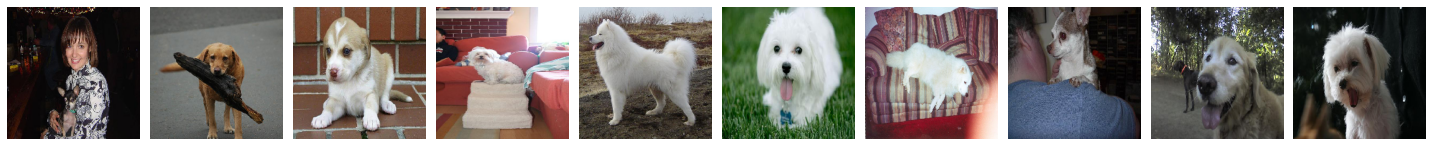

['Chihuahua', 'golden_retriever', 'Chihuahua', 'Maltese_dog', 'Samoyed', 'Maltese_dog', 'Samoyed', 'Chihuahua', 'golden_retriever', 'Maltese_dog']


Validation set :


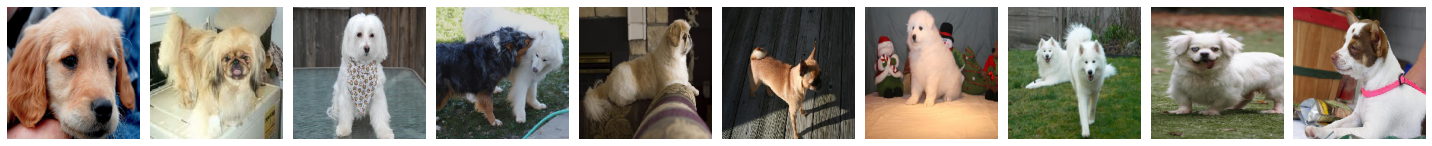

['golden_retriever', 'Pekinese', 'Maltese_dog', 'Samoyed', 'Pekinese', 'Chihuahua', 'Samoyed', 'Samoyed', 'Pekinese', 'Chihuahua']


Test set :


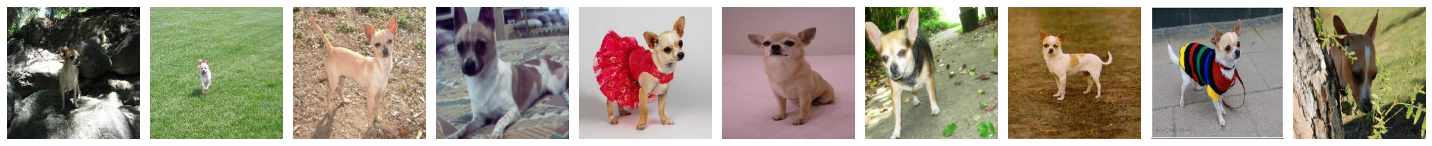

['Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua']


In [ ]:
print('Train set :')
plotImages(imgs_train)
print([dog_breeds[i] for i in np.argmax(labels_train, axis=1)])
print('\n')
print('Validation set :')
plotImages(imgs_valid)
print([dog_breeds[i] for i in np.argmax(labels_valid, axis=1)])
print('\n')
print('Test set :')
plotImages(imgs_test)
print([dog_breeds[i] for i in np.argmax(labels_test, axis=1)])

Pour le test set, on observe des images d'un même classe. Cela s'explique par le shuffle = False lors de la création des batchs.

# Création du premier modèle VGG16

In [ ]:
# On construit notre CNN

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


my_VGG16 = Sequential() # Création d'un réseau de neurones vide 

# BLOC 1

# Ajout de la première couche convolutive : input_shape car première couche, padding='same' pour conserver la taille de l'image
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))

# Ajout de la seconde couche convolutive
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
my_VGG16.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# BLOC 2

# Ajout de la première couche convolutive : input_shape car première couche, padding='same' pour conserver la taille de l'image
my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

# Ajout de la seconde couche convolutive
my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
my_VGG16.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# BLOC 3

# Ajout de la première couche convolutive : input_shape car première couche, padding='same' pour conserver la taille de l'image
my_VGG16.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

# Ajout de la seconde couche convolutive
my_VGG16.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
my_VGG16.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# BLOC 4

# Ajout de la première couche convolutive : input_shape car première couche, padding='same' pour conserver la taille de l'image
my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

# Ajout de la seconde couche convolutive
my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
my_VGG16.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# BLOC TOP

# Conversion des matrices 3D en matrices 1D
my_VGG16.add(Flatten())

# Ajout de la première couche fully connected
my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la deuxième couche fully connected
my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

# On peut hyperoptimiser ces paramètres, categorical_crossentropy avec softmax pour la dernière couche
# commun pour une classification à plus de deux catégories
my_VGG16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
my_VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [ ]:
valid_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [ ]:
# On sauvegarde les poids random
my_VGG16.save_weights('model_initial.h5')

In [ ]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
start = datetime.now()

results = my_VGG16.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=1, callbacks=[callback] )
print("Time taken to run this cell :", datetime.now() - start)

Epoch 1/30
55/55 [==============================] - 360s 6s/step - loss: 1.6138 - accuracy: 0.1673 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/30
55/55 [==============================] - 26s 466ms/step - loss: 1.6100 - accuracy: 0.1709 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/30
55/55 [==============================] - 26s 464ms/step - loss: 1.6097 - accuracy: 0.1982 - val_loss: 1.6094 - val_accuracy: 0.2400
Epoch 4/30
55/55 [==============================] - 25s 463ms/step - loss: 1.6301 - accuracy: 0.2055 - val_loss: 1.6094 - val_accuracy: 0.1867
Epoch 5/30
55/55 [==============================] - 25s 461ms/step - loss: 1.6093 - accuracy: 0.1891 - val_loss: 1.5856 - val_accuracy: 0.3467
Epoch 6/30
55/55 [==============================] - 26s 463ms/step - loss: 1.5503 - accuracy: 0.2673 - val_loss: 1.4696 - val_accuracy: 0.3067
Epoch 7/30
55/55 [==============================] - 25s 462ms/step - loss: 1.4447 - accuracy: 0.3145 - val_loss: 1.3331 - val_accuracy: 0.3333
E

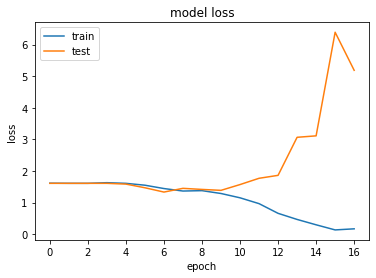

In [ ]:
# summarize history for loss
plt.plot(pd.Series(results.history['loss']))
plt.plot(pd.Series(results.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

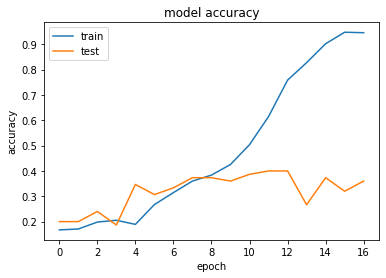

In [ ]:
# summarize history for loss
plt.plot(pd.Series(results.history['accuracy']))
plt.plot(pd.Series(results.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Sur ce premier modèle, on observe que la courbe loss ne parvinet pas à converger. Au contraire, plus on entraîne le modèle et plus il overfit le jeu d'entrainement.

On peut observer les classes réelles de notre jeu de test.

In [ ]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4], dtype=int32)

Regardons maintenant les performances de notre modèle sur le jeu de test. 
Afin d'avoir un aperçu visuel de ces résultats pour les 5 classes testées, on affiche la matrice de confusion.

In [ ]:
# On réalise maintenant les prédictions sur notre jeu de test
predictions = my_VGG16.predict(x=test_batches, verbose=0)
predictions[:5]

array([[7.1875745e-01, 2.0129859e-01, 2.8788716e-02, 3.0328609e-02,
        2.0826695e-02],
       [1.3988769e-01, 7.9175621e-02, 4.4283399e-01, 1.8139373e-01,
        1.5670894e-01],
       [8.2673535e-02, 1.0314089e-03, 1.8254767e-01, 7.3367435e-01,
        7.3032970e-05],
       [5.0277758e-02, 1.3493496e-01, 3.6094102e-01, 5.5327516e-02,
        3.9851868e-01],
       [5.7556974e-16, 1.8838099e-24, 7.9100115e-10, 1.0000000e+00,
        3.6371630e-27]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))
cm

array([[2, 1, 4, 2, 1],
       [2, 0, 4, 2, 2],
       [3, 1, 3, 2, 1],
       [3, 0, 3, 4, 0],
       [0, 2, 1, 1, 6]])

In [ ]:
# On s'assure que les labels sont dans le bon ordre
test_batches.class_indices

{'Chihuahua': 0,
 'Maltese_dog': 1,
 'Pekinese': 2,
 'Samoyed': 4,
 'golden_retriever': 3}

In [ ]:
dog_breeds

['Chihuahua', 'Maltese_dog', 'Pekinese', 'golden_retriever', 'Samoyed']

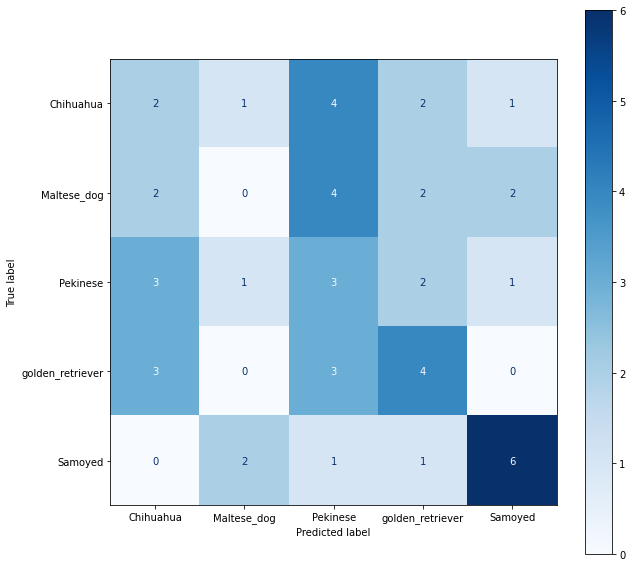

In [ ]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dog_breeds)
fig, ax = plt.subplots(figsize=(10,10))
cm_plot.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
# On peut réiniltialiser les poids du modèle
# model.save_weights('model_initial.h5')
# model.load_weights('model_initial.h5')

# Initialiser le modèle, sauver les poids, entrainer scorer le modèle puis recharger les poids initialisés aléatoirement



# Regarder les callbacks pour arrêter l'entrainement du modèle comme convenu
# On peut enregistrer les poids d'un modèle à l'aide d'un callback


# Regarder l'impact du drop out sur le sur apprentissage 

# Preprocessing


In [ ]:
# On applique le pre_processing standard appliqué en entrée du modèle VGG16
# The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input, rescale = 1./255).flow_from_directory(directory=train_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input, rescale = 1./255).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input, rescale = 1./255).flow_from_directory(directory=test_path, target_size=(224, 224), classes=dog_breeds, batch_size=10, shuffle=False)

Found 550 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [ ]:
# On réinitialise les poids du modèle
my_VGG16.load_weights('model_initial.h5')

In [ ]:
start = datetime.now()
results = my_VGG16.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=1, callbacks=[callback])
print("Time taken to run this cell :", datetime.now() - start)

Epoch 1/30
55/55 [==============================] - 26s 468ms/step - loss: 1.6027 - accuracy: 0.1909 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/30
55/55 [==============================] - 26s 463ms/step - loss: 1.6100 - accuracy: 0.1873 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/30
55/55 [==============================] - 26s 463ms/step - loss: 1.6093 - accuracy: 0.1964 - val_loss: 1.5807 - val_accuracy: 0.2800
Epoch 4/30
55/55 [==============================] - 26s 465ms/step - loss: 1.5405 - accuracy: 0.2945 - val_loss: 1.4204 - val_accuracy: 0.3200
Epoch 5/30
55/55 [==============================] - 26s 464ms/step - loss: 1.4090 - accuracy: 0.3564 - val_loss: 1.4139 - val_accuracy: 0.3200
Epoch 6/30
55/55 [==============================] - 26s 463ms/step - loss: 1.3589 - accuracy: 0.3455 - val_loss: 1.2913 - val_accuracy: 0.3600
Epoch 7/30
55/55 [==============================] - 26s 464ms/step - loss: 1.3048 - accuracy: 0.4055 - val_loss: 1.3206 - val_accuracy: 0.4133

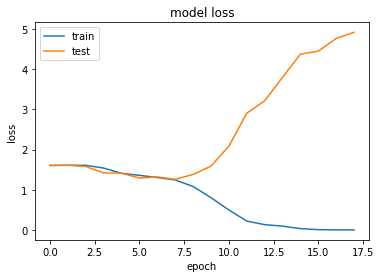

In [ ]:
# summarize history for loss
plt.plot(pd.Series(results.history['loss']))
plt.plot(pd.Series(results.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

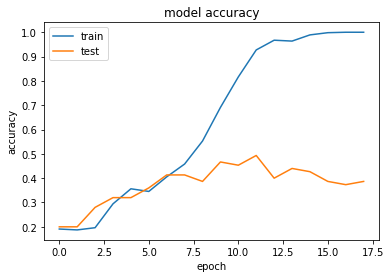

In [ ]:
# summarize history for accuracy
plt.plot(pd.Series(results.history['accuracy']))
plt.plot(pd.Series(results.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

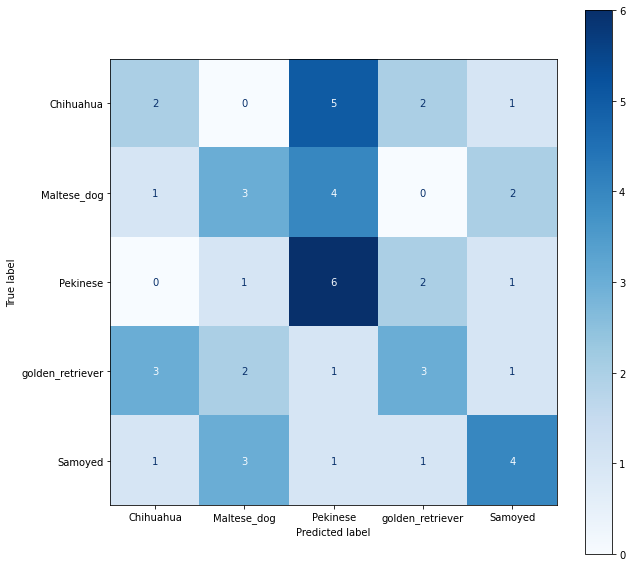

In [ ]:
# On réalise maintenant les prédictions sur notre jeu de test
predictions = my_VGG16.predict(x=test_batches, verbose=0)
predictions

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dog_breeds)
fig, ax = plt.subplots(figsize=(10,10))
cm_plot.plot(ax=ax, cmap=plt.cm.Blues)

# Data Augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# On applique le pre_processing standard appliqué en entrée du modèle VGG16


train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale = 1./255).flow_from_directory(directory=train_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale = 1./255).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale = 1./255).flow_from_directory(directory=test_path, target_size=(224, 224), classes=dog_breeds, batch_size=10, shuffle=False)

Found 550 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [ ]:
imgs_train, labels_train = next(train_batches)
imgs_valid, labels_valid = next(valid_batches)
imgs_test, labels_test = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train set :


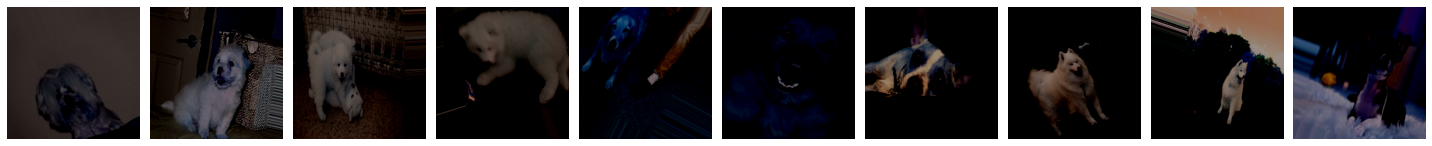

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['Maltese_dog', 'Maltese_dog', 'Samoyed', 'Samoyed', 'golden_retriever', 'golden_retriever', 'Chihuahua', 'Samoyed', 'Samoyed', 'Chihuahua']


Validation set :


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


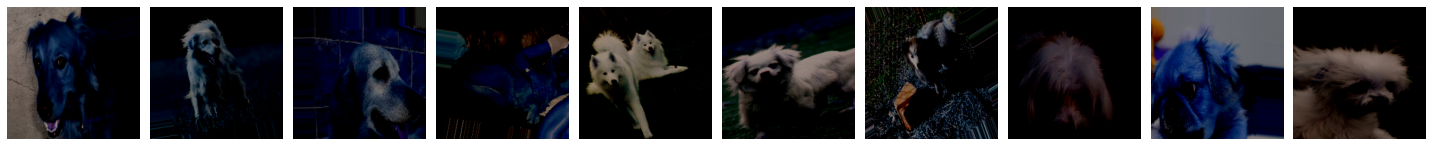

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['golden_retriever', 'golden_retriever', 'golden_retriever', 'golden_retriever', 'Samoyed', 'Pekinese', 'Samoyed', 'Maltese_dog', 'Pekinese', 'Maltese_dog']


Test set :


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


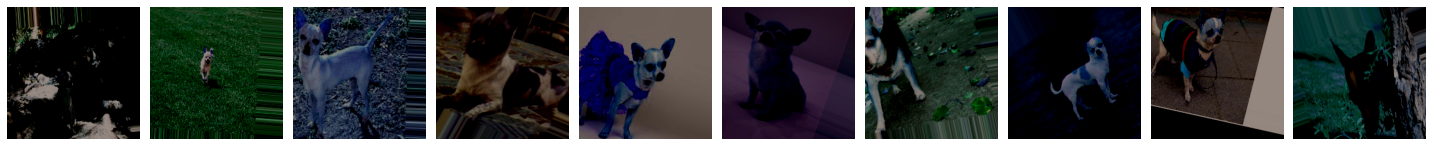

['Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua']


In [ ]:
print('Train set :')
plotImages(imgs_train)
print([dog_breeds[i] for i in np.argmax(labels_train, axis=1)])
print('\n')
print('Validation set :')
plotImages(imgs_valid)
print([dog_breeds[i] for i in np.argmax(labels_valid, axis=1)])
print('\n')
print('Test set :')
plotImages(imgs_test)
print([dog_breeds[i] for i in np.argmax(labels_test, axis=1)])

In [ ]:
# On réinitialise les poids du modèle
my_VGG16.load_weights('model_initial.h5')

In [ ]:
start = datetime.now()
results = my_VGG16.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=1, callbacks=[callback])
print("Time taken to run this cell :", datetime.now() - start)

Epoch 1/30
55/55 [==============================] - 27s 480ms/step - loss: 1.6076 - accuracy: 0.1800 - val_loss: 1.6073 - val_accuracy: 0.2267
Epoch 2/30
55/55 [==============================] - 26s 475ms/step - loss: 1.5881 - accuracy: 0.2418 - val_loss: 1.5579 - val_accuracy: 0.2933
Epoch 3/30
55/55 [==============================] - 26s 474ms/step - loss: 1.5309 - accuracy: 0.3291 - val_loss: 1.5144 - val_accuracy: 0.2800
Epoch 4/30
55/55 [==============================] - 26s 473ms/step - loss: 1.4587 - accuracy: 0.3291 - val_loss: 1.4162 - val_accuracy: 0.3467
Epoch 5/30
55/55 [==============================] - 26s 473ms/step - loss: 1.4213 - accuracy: 0.3236 - val_loss: 1.4075 - val_accuracy: 0.4000
Epoch 6/30
55/55 [==============================] - 26s 473ms/step - loss: 1.4325 - accuracy: 0.3527 - val_loss: 1.4840 - val_accuracy: 0.3067
Epoch 7/30
55/55 [==============================] - 26s 473ms/step - loss: 1.4322 - accuracy: 0.3473 - val_loss: 1.4629 - val_accuracy: 0.2800

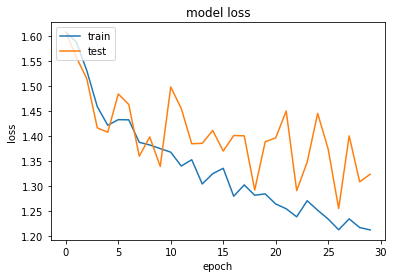

In [ ]:
# summarize history for loss
plt.plot(pd.Series(results.history['loss']))
plt.plot(pd.Series(results.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

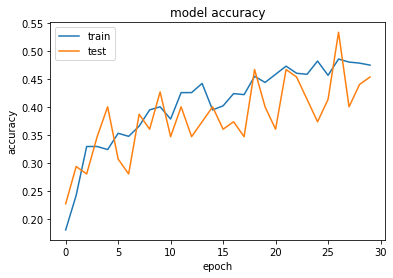

In [ ]:
# summarize history for accuracy
plt.plot(pd.Series(results.history['accuracy']))
plt.plot(pd.Series(results.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

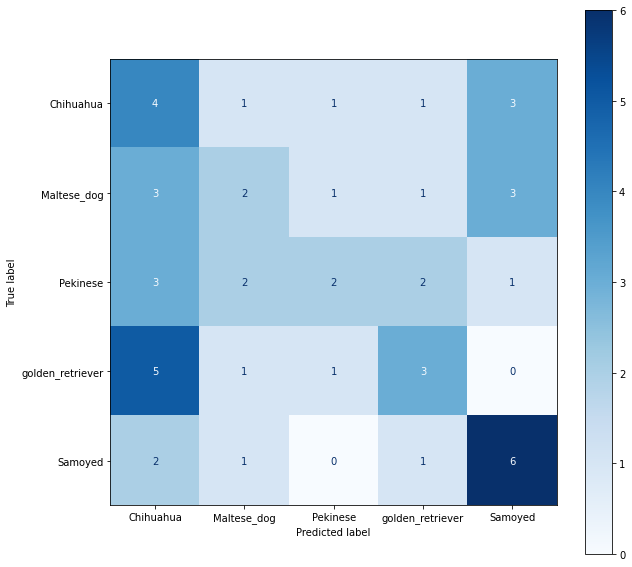

In [ ]:
# On réalise maintenant les prédictions sur notre jeu de test
predictions = my_VGG16.predict(x=test_batches, verbose=0)
predictions

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dog_breeds)
fig, ax = plt.subplots(figsize=(10,10))
cm_plot.plot(ax=ax, cmap=plt.cm.Blues)

# Transfer Learning

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=dog_breeds, batch_size=10, shuffle=False)

Found 550 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# On construit le nouveau modèle
new_model = Sequential()

for layer in model.layers[:-1]:
   new_model.add(layer)

new_model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_____________________________________________________

In [ ]:
for layer in new_model.layers:
   layer.trainable = False

# Ajout de la dernière couche fully-connected qui permet de classifier
new_model.add(Dense(5, activation='softmax'))

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

start = datetime.now()
# Entraîner sur les données d'entraînement
model_info = new_model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=1, callbacks=[callback])
print("Time taken to run this cell :", datetime.now() - start)

Epoch 1/30
55/55 [==============================] - 10s 161ms/step - loss: 1.2509 - accuracy: 0.5836 - val_loss: 0.5856 - val_accuracy: 0.8400
Epoch 2/30
55/55 [==============================] - 9s 154ms/step - loss: 0.3056 - accuracy: 0.9055 - val_loss: 0.3870 - val_accuracy: 0.8933
Epoch 3/30
55/55 [==============================] - 9s 154ms/step - loss: 0.1865 - accuracy: 0.9436 - val_loss: 0.3454 - val_accuracy: 0.9333
Epoch 4/30
55/55 [==============================] - 9s 155ms/step - loss: 0.1335 - accuracy: 0.9582 - val_loss: 0.3155 - val_accuracy: 0.9333
Epoch 5/30
55/55 [==============================] - 9s 155ms/step - loss: 0.0956 - accuracy: 0.9800 - val_loss: 0.2927 - val_accuracy: 0.9467
Epoch 6/30
55/55 [==============================] - 9s 154ms/step - loss: 0.0723 - accuracy: 0.9836 - val_loss: 0.2837 - val_accuracy: 0.9467
Epoch 7/30
55/55 [==============================] - 9s 155ms/step - loss: 0.0562 - accuracy: 0.9945 - val_loss: 0.2711 - val_accuracy: 0.9600
Epoch

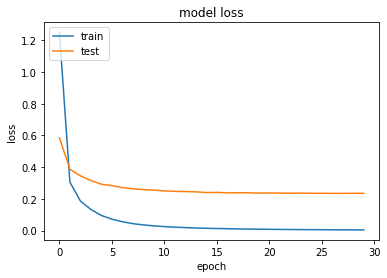

In [ ]:
# summarize history for loss
plt.plot(pd.Series(model_info.history['loss']))
plt.plot(pd.Series(model_info.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

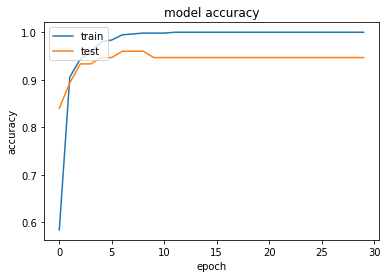

In [ ]:
# summarize history for accuracy
plt.plot(pd.Series(model_info.history['accuracy']))
plt.plot(pd.Series(model_info.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

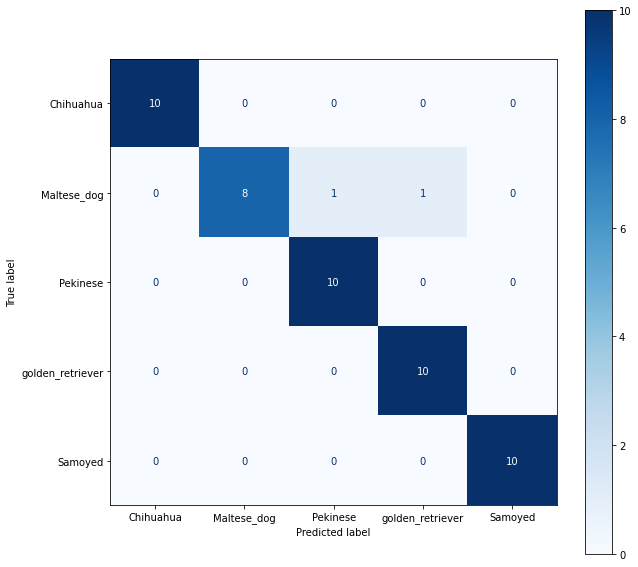

In [ ]:
# On réalise maintenant les prédictions sur notre jeu de test
predictions = new_model.predict(x=test_batches, verbose=0)
predictions

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dog_breeds)
fig, ax = plt.subplots(figsize=(10,10))
cm_plot.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# On applique le pre_processing standard appliqué en entrée du modèle VGG16


train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest").flow_from_directory(directory=train_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest").flow_from_directory(directory=valid_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest").flow_from_directory(directory=test_path, target_size=(224, 224), classes=dog_breeds, batch_size=10, shuffle=False)

Found 550 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [ ]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# On construit le nouveau modèle
new_model = Sequential()

for layer in model.layers[:-1]:
   new_model.add(layer)

for layer in new_model.layers:
   layer.trainable = False

# Ajout de la dernière couche fully-connected qui permet de classifier
new_model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate=0.0001)

# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

start = datetime.now()
# Entraîner sur les données d'entraînement
model_info = new_model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=1, callbacks=[callback])
print("Time taken to run this cell :", datetime.now() - start)

Epoch 1/30
55/55 [==============================] - 14s 243ms/step - loss: 1.1951 - accuracy: 0.5927 - val_loss: 0.5652 - val_accuracy: 0.8000
Epoch 2/30
55/55 [==============================] - 13s 238ms/step - loss: 0.3960 - accuracy: 0.8782 - val_loss: 0.3825 - val_accuracy: 0.8800
Epoch 3/30
55/55 [==============================] - 13s 238ms/step - loss: 0.2686 - accuracy: 0.9145 - val_loss: 0.2981 - val_accuracy: 0.9333
Epoch 4/30
55/55 [==============================] - 13s 239ms/step - loss: 0.2242 - accuracy: 0.9309 - val_loss: 0.2144 - val_accuracy: 0.9333
Epoch 5/30
55/55 [==============================] - 13s 238ms/step - loss: 0.1492 - accuracy: 0.9582 - val_loss: 0.2925 - val_accuracy: 0.8933
Epoch 6/30
55/55 [==============================] - 13s 240ms/step - loss: 0.1463 - accuracy: 0.9491 - val_loss: 0.2723 - val_accuracy: 0.9333
Epoch 7/30
55/55 [==============================] - 13s 239ms/step - loss: 0.1339 - accuracy: 0.9527 - val_loss: 0.2308 - val_accuracy: 0.9333

#Test du modèle final sur l'intégralité du jeu de donnée

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/OC_Classez_des_images/Images_2"

affenpinscher			keeshond
Afghan_hound			kelpie
African_hunting_dog		Kerry_blue_terrier
Airedale			komondor
American_Staffordshire_terrier	kuvasz
Appenzeller			Labrador_retriever
Australian_terrier		Lakeland_terrier
basenji				Leonberg
basset				Lhasa
beagle				malamute
Bedlington_terrier		malinois
Bernese_mountain_dog		Maltese_dog
black-and-tan_coonhound		Mexican_hairless
Blenheim_spaniel		miniature_pinscher
bloodhound			miniature_poodle
bluetick			miniature_schnauzer
Border_collie			Newfoundland
Border_terrier			Norfolk_terrier
borzoi				Norwegian_elkhound
Boston_bull			Norwich_terrier
Bouvier_des_Flandres		Old_English_sheepdog
boxer				otterhound
Brabancon_griffon		papillon
briard				Pekinese
Brittany_spaniel		Pembroke
bull_mastiff			Pomeranian
cairn				pug
Cardigan			redbone
Chesapeake_Bay_retriever	Rhodesian_ridgeback
Chihuahua			Rottweiler
chow				Saint_Bernard
clumber				Saluki
cocker_spaniel			Samoyed
collie				schipperke
curly-coated_retriever		Scotch_terrier
Dandie_Dinmont			S

In [ ]:
images_path = "/content/drive/My Drive/Colab Notebooks/OC_Classez_des_images/Images_2"

dog_breeds = os.listdir(images_path)

# On retire les fichiers de photos déjà créés par les précédents Kernel
to_del = ['train', 'valid', 'test']
for dir in to_del:
  if dir in dog_breeds: dog_breeds.remove(dir)

nb_pics_breeds = []

for breed in dog_breeds:
    nb_pics = len([name for name in os.listdir(os.path.join(images_path, breed))])
    nb_pics_breeds.append([breed, nb_pics])

In [ ]:
# A afficher si première éxécution, nombre de photo de chaque chiens
#pd.DataFrame(data= nb_pics_breeds, columns=['Race', 'Nb_img'])

In [ ]:
dog_breeds

['Brabancon_griffon',
 'soft-coated_wheaten_terrier',
 'Irish_water_spaniel',
 'groenendael',
 'black-and-tan_coonhound',
 'Leonberg',
 'French_bulldog',
 'curly-coated_retriever',
 'Pomeranian',
 'Yorkshire_terrier',
 'English_springer',
 'Boston_bull',
 'clumber',
 'Brittany_spaniel',
 'Great_Pyrenees',
 'Welsh_springer_spaniel',
 'Afghan_hound',
 'toy_poodle',
 'dingo',
 'Appenzeller',
 'Airedale',
 'bloodhound',
 'basenji',
 'Irish_setter',
 'Bedlington_terrier',
 'beagle',
 'Great_Dane',
 'Dandie_Dinmont',
 'Samoyed',
 'keeshond',
 'collie',
 'cairn',
 'Lhasa',
 'Australian_terrier',
 'toy_terrier',
 'Shetland_sheepdog',
 'Walker_hound',
 'African_hunting_dog',
 'Newfoundland',
 'Rottweiler',
 'Italian_greyhound',
 'Scotch_terrier',
 'affenpinscher',
 'English_setter',
 'otterhound',
 'flat-coated_retriever',
 'Shih-Tzu',
 'Labrador_retriever',
 'Sussex_spaniel',
 'whippet',
 'chow',
 'kelpie',
 'Weimaraner',
 'vizsla',
 'pug',
 'miniature_pinscher',
 'American_Staffordshire_terri

In [ ]:
import random
import glob
import shutil

if os.path.isdir(os.path.join(images_path, 'train')) is False:
  os.makedirs(os.path.join(images_path, 'train'))

for breed in dog_breeds:
  if os.path.isdir(os.path.join(images_path, 'train', breed)) is False:
    os.makedirs(os.path.join(images_path, 'train', breed))
    for c in random.sample(glob.glob(os.path.join(images_path, breed,'*')), 110):
      shutil.move(c, os.path.join(images_path, 'train', breed))
  if os.path.isdir(os.path.join(images_path, 'valid', breed)) is False:
    os.makedirs(os.path.join(images_path, 'valid', breed))
    for c in random.sample(glob.glob(os.path.join(images_path, breed,'*')), 15):
      shutil.move(c, os.path.join(images_path, 'valid', breed))
  if os.path.isdir(os.path.join(images_path, 'test', breed)) is False:
    os.makedirs(os.path.join(images_path, 'test', breed))
    for c in random.sample(glob.glob(os.path.join(images_path, breed,'*')), 10):
      shutil.move(c, os.path.join(images_path, 'test', breed))

In [ ]:
train_path = os.path.join(images_path, 'train')
valid_path = os.path.join(images_path, 'valid')
test_path = os.path.join(images_path, 'test')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# On applique le pre_processing standard appliqué en entrée du modèle VGG16


train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=dog_breeds, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=dog_breeds, batch_size=10, shuffle=False)

Found 13090 images belonging to 120 classes.
Found 1800 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.


In [ ]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# On construit le nouveau modèle
new_model = Sequential()

for layer in model.layers[:-1]:
   new_model.add(layer)

for layer in new_model.layers:
   layer.trainable = False

# Ajout de la dernière couche fully-connected qui permet de classifier
new_model.add(Dense(120, activation='softmax'))

opt = Adam(learning_rate=0.0001)

# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

start = datetime.now()
# Entraîner sur les données d'entraînement
model_info = new_model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=1, callbacks=[callback])
print("Time taken to run this cell :", datetime.now() - start)

Epoch 1/30
1309/1309 [==============================] - 6339s 5s/step - loss: 1.7084 - accuracy: 0.5568 - val_loss: 1.1437 - val_accuracy: 0.6917
Epoch 2/30
1309/1309 [==============================] - 198s 151ms/step - loss: 0.6558 - accuracy: 0.7947 - val_loss: 1.0833 - val_accuracy: 0.7267
Epoch 3/30
1309/1309 [==============================] - 197s 150ms/step - loss: 0.4094 - accuracy: 0.8716 - val_loss: 1.0812 - val_accuracy: 0.7222
Epoch 4/30
1309/1309 [==============================] - 197s 151ms/step - loss: 0.2644 - accuracy: 0.9248 - val_loss: 1.0765 - val_accuracy: 0.7400
Epoch 5/30
1309/1309 [==============================] - 198s 151ms/step - loss: 0.1710 - accuracy: 0.9589 - val_loss: 1.0938 - val_accuracy: 0.7322
Epoch 6/30
1309/1309 [==============================] - 197s 150ms/step - loss: 0.1164 - accuracy: 0.9756 - val_loss: 1.1350 - val_accuracy: 0.7294
Epoch 7/30
1309/1309 [==============================] - 196s 150ms/step - loss: 0.0780 - accuracy: 0.9872 - val_lo

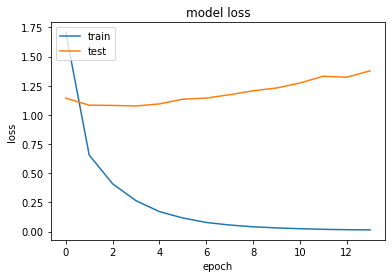

In [ ]:
# summarize history for loss
plt.plot(pd.Series(model_info.history['loss']))
plt.plot(pd.Series(model_info.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

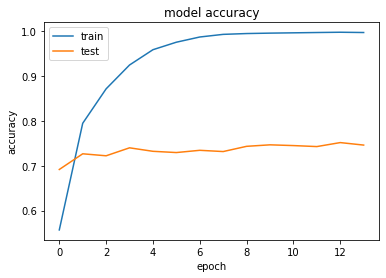

In [ ]:
# summarize history for accuracy
plt.plot(pd.Series(model_info.history['accuracy']))
plt.plot(pd.Series(model_info.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# On réalise maintenant les prédictions sur notre jeu de test
predictions = new_model.predict(x=test_batches, verbose=0)
predictions

array([[2.42384712e-14, 3.05482778e-10, 1.23003436e-17, ...,
        1.62475692e-14, 2.75131419e-21, 3.39641133e-08],
       [6.27275402e-12, 8.82781386e-01, 7.44015571e-10, ...,
        4.93046059e-07, 3.10453669e-14, 2.80149709e-10],
       [2.17681581e-15, 1.51677032e-10, 1.98782448e-19, ...,
        7.42255649e-14, 1.81858913e-23, 7.84949691e-07],
       ...,
       [3.58681695e-10, 1.63632421e-06, 3.77008774e-14, ...,
        1.68981202e-07, 1.25594412e-14, 4.76695714e-04],
       [6.15489187e-11, 3.40507911e-09, 1.54395366e-12, ...,
        2.24634844e-09, 3.79177707e-17, 9.93277967e-01],
       [1.35592509e-11, 1.31168285e-08, 8.32039299e-16, ...,
        2.08694553e-14, 2.38266874e-16, 5.17603338e-01]], dtype=float32)

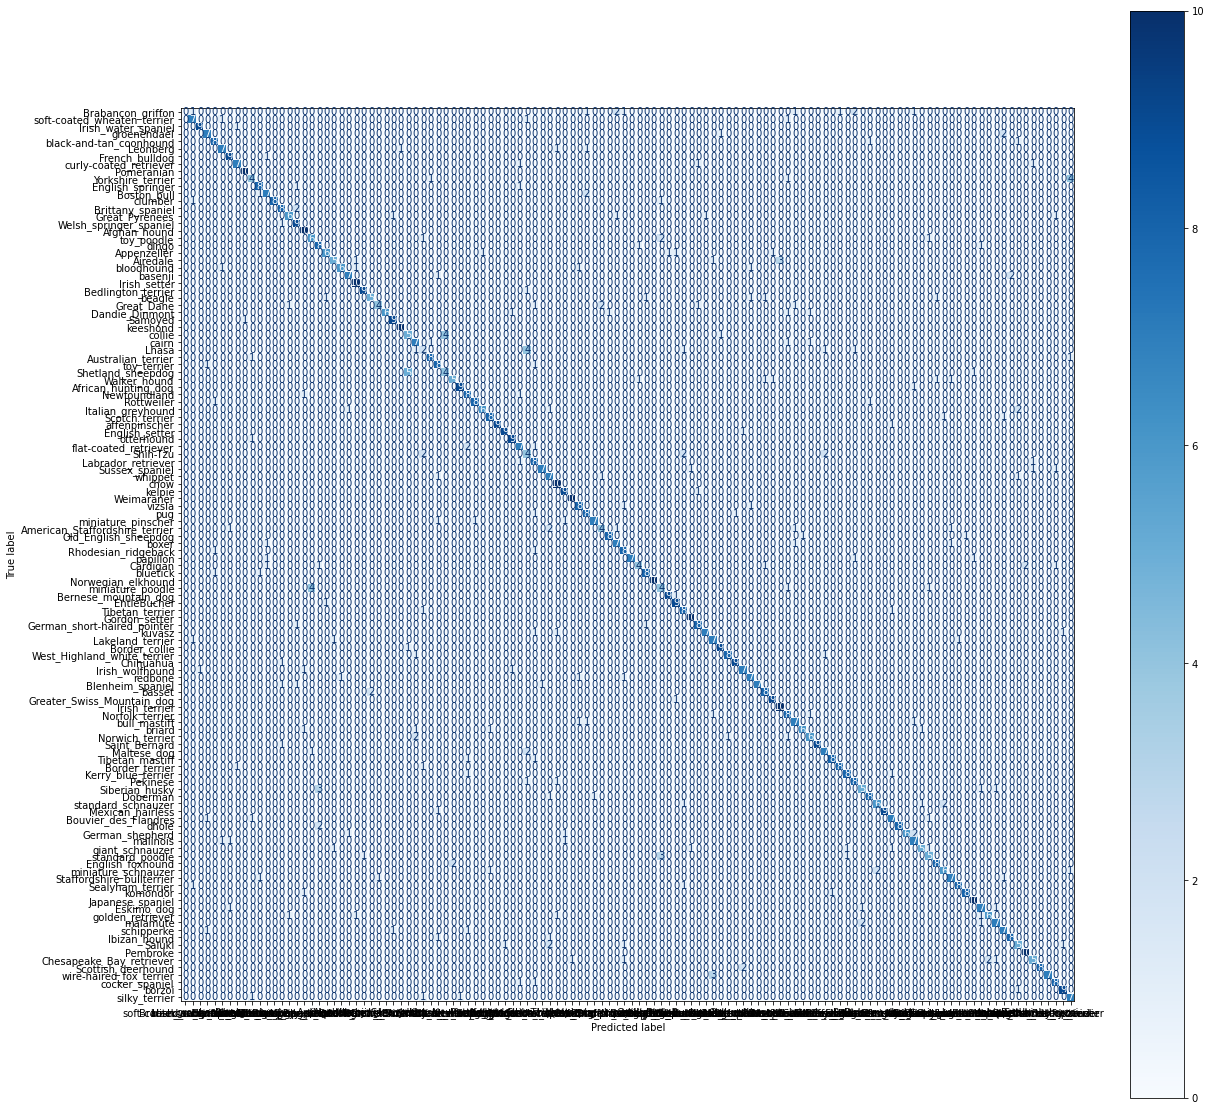

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dog_breeds)
fig, ax = plt.subplots(figsize=(20,20))
cm_plot.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
final_model_path = "/content/drive/My Drive/Colab Notebooks/OC_Classez_des_images"

In [ ]:
new_model.save(os.path.join(final_model_path, 'final_model.h5'))

# Prédire la race d'un chien à partir d'un array

In [ ]:
import keras

# on récupère notre modèle
reconstructed_model = keras.models.load_model(os.path.join(final_model_path, 'final_model.h5'))

# on récupère une image dans le jeu de test
image = tensorflow.keras.preprocessing.image.load_img(path='/content/drive/My Drive/Colab Notebooks/OC_Classez_des_images/Images_2/test/Brabancon_griffon/n02112706_108.jpg', target_size=(224, 224))

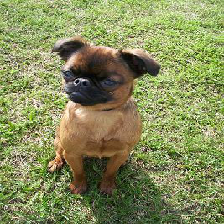

In [ ]:
image

In [ ]:
from keras.preprocessing.image import img_to_array, save_img, array_to_img

# on part d'un array
arr_img = img_to_array(image)

# on convertit cet array en image
img = array_to_img(arr_img)

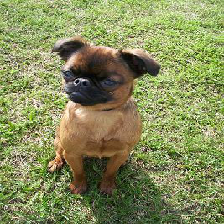

In [ ]:
img

In [ ]:
# on applique le préprocessing à notre image
x = np.expand_dims(img, axis=0)
exemple = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow(x, batch_size=1)

# on prédit sa classe
dog_breeds[int(new_model.predict(exemple).argmax(axis=1))]

'Pekinese'

# Fichier .py

In [ ]:
import keras
import tensorflow

final_model_path = 'path'

dog_breeds = pd.read_csv('dog_breeds')

# on récupère notre modèle
reconstructed_model = keras.models.load_model(os.path.join(final_model_path, 'final_model.h5'))

# on récupère une image dans le jeu de test
image = tensorflow.keras.preprocessing.image.load_img(path='image_path', target_size=(224, 224))

# on applique le préprocessing à notre image
x = np.expand_dims(img, axis=0)
exemple = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input).flow(x, batch_size=1)

# on prédit sa classe
print(dog_breeds.iloc[int(new_model.predict(exemple).argmax(axis=1))])